In [83]:
import pandas as pd
from datetime import datetime
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.python.keras.layers.recurrent import LSTM, SimpleRNN, GRU

# Functions

In [84]:
def create_lookback_dataset(data, look_back=15):
    dataX, dataY = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [85]:
def train_and_predict(model, data, test_size=0.8, look_back=24, reccurent=False):
    # Transforme data -> [0,1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data['count'].values.reshape(-1, 1))

    train_size = int(len(data_scaled) * test_size)
    test_size = len(data_scaled) - train_size
    times_test = data["Time"][train_size:len(data_scaled)]
    train, test = data_scaled[0:train_size], data_scaled[train_size:len(data_scaled)]

    x_train, y_train = create_dataset(train, look_back=look_back)
    x_test, y_test = create_dataset(test, look_back=look_back)

    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

    model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=0)
    test_predictions=model.predict(x_test)
    if not reccurent:
        test_predictions = np.squeeze(test_predictions, axis=(2,))
    

    test_predictions = scaler.inverse_transform(test_predictions)
    test_actual = scaler.inverse_transform([y_test])

    score = mean_squared_error(test_actual[0], test_predictions[:,0], squared=False),
    
    return {
        "real_values":test_actual[0],
        "values":test_predictions[:,0],
        "score":score,
        "score_relative":score/test_actual[0].mean()
    }


In [86]:
def plot_prediction(prediction):
    plt.figure(figsize=(15,5))
    plt.plot(prediction["real_values"], label="actual")
    plt.plot(prediction["values"], label="predicted")
    plt.legend()
    plt.show()

# Predictions Base

In [87]:
df = pd.read_csv("data/hourly_main_bases_2015.csv",index_col=0)
df["Time"] = pd.to_datetime(df["Time"])
display(df.describe())
# Exemple avec la base B02764
c = "Base_B02764"
data = df[["Time",c]].rename(columns={c:"count"})
data

,Base_B02512,Base_B02598,Base_B02617,Base_B02682,Base_B02764,Base_B02765
count,4344.000000,4344.000000,4344.000000,4344.000000,4344.000000,4344.000000
mean,43.303867,296.437155,448.188996,793.899171,1001.915516,239.037523
std,35.494782,169.409745,249.287272,621.239909,570.361505,176.347315
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,161.000000,253.750000,337.750000,586.500000,77.000000
50%,44.000000,285.000000,433.000000,615.000000,956.000000,234.000000
75%,68.000000,400.000000,602.000000,1119.000000,1318.000000,350.000000
max,175.000000,911.000000,1307.000000,4192.000000,2956.000000,876.000000


,Time,count
0,2015-01-01 00:00:00,2483.0
1,2015-01-01 01:00:00,2241.0
2,2015-01-01 02:00:00,2625.0
3,2015-01-01 03:00:00,2216.0
4,2015-01-01 04:00:00,1551.0
...,...,...
4339,2015-06-30 19:00:00,1182.0
4340,2015-06-30 20:00:00,1104.0
4341,2015-06-30 21:00:00,1264.0
4342,2015-06-30 22:00:00,1246.0


In [88]:
# look_back parametrable (nombre d'heures)
look_back = 24*7

## Dense

22/22 [==============================] - 0s 619us/step
Test Score: 136.17 RMSE
Test Score (relative): 0.15 RMSE


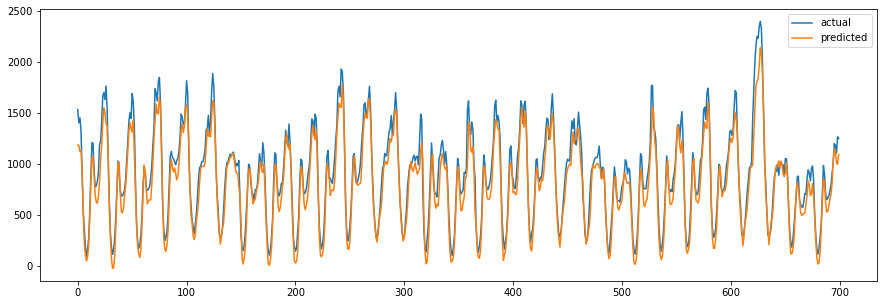

In [89]:
model = Sequential()
model.add(Dense(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

prediction = train_and_predict(model, data ,look_back=look_back)
print('Test Score: %.2f RMSE' % (prediction["score"]))
print('Test Score (relative): %.2f RMSE' % (prediction["score_relative"]))
plot_prediction(prediction)

## RNN

22/22 [==============================] - 0s 762us/step
Test Score: 94.97 RMSE
Test Score (relative): 0.11 RMSE


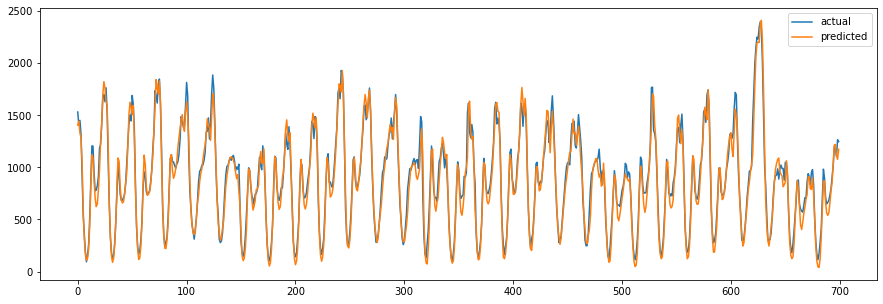

In [90]:
model = Sequential()
model.add(SimpleRNN(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

prediction = train_and_predict(model, data ,look_back=look_back, reccurent=True)
print('Test Score: %.2f RMSE' % (prediction["score"]))
print('Test Score (relative): %.2f RMSE' % (prediction["score_relative"]))
plot_prediction(prediction)

## LSTM

22/22 [==============================] - 0s 762us/step
Test Score: 82.44 RMSE
Test Score (relative): 0.09 RMSE


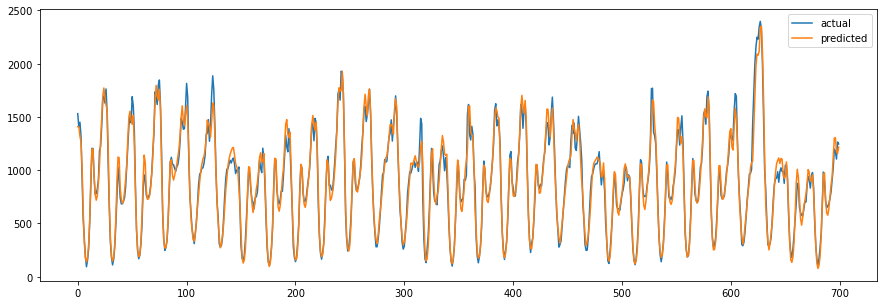

In [91]:
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

prediction = train_and_predict(model, data ,look_back=look_back, reccurent=True)
print('Test Score: %.2f RMSE' % (prediction["score"]))
print('Test Score (relative): %.2f RMSE' % (prediction["score_relative"]))
plot_prediction(prediction)

# Predictions Location

In [92]:
df = pd.read_csv("data/hourly_main_locations_15.csv",index_col=0)
df["Time"] = pd.to_datetime(df["Time"])
display(df.describe())

,Location_48,Location_68,Location_79,Location_107,Location_132,Location_138,Location_144,Location_148,Location_158,Location_161,Location_162,Location_163,Location_164,Location_170,Location_230,Location_231,Location_234,Location_237,Location_246,Location_249
count,4344.000000,4344.000000,4344.000000,4344.000000,4344.000000,4344.000000,4344.000000,4344.000000,4344.000000,4344.000000,4344.000000,4344.000000,4344.000000,4344.000000,4344.000000,4344.000000,4344.000000,4344.000000,4344.000000,4344.000000
mean,59.183011,69.010359,93.828499,57.895718,66.567449,61.261280,58.748158,58.196363,61.574586,106.061694,65.726980,68.308932,61.664595,66.885359,72.725368,96.767035,96.465239,65.495856,64.249540,74.583103
std,35.482385,42.661060,74.417745,37.968465,53.000602,56.582654,42.380475,50.498431,44.802768,112.229894,63.550054,54.679203,45.067857,46.888723,59.650917,61.986822,77.649906,50.044323,50.524483,63.370625
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.000000,38.000000,47.000000,30.000000,26.000000,4.000000,25.000000,27.000000,31.000000,23.000000,19.000000,24.000000,25.000000,30.000000,31.000000,48.000000,35.000000,19.000000,25.000000,34.000000
50%,54.000000,63.000000,74.000000,52.000000,57.000000,53.000000,49.500000,43.000000,52.000000,64.000000,46.000000,56.000000,52.000000,59.000000,56.000000,91.000000,76.500000,64.000000,55.000000,57.000000
75%,77.000000,92.000000,117.000000,80.000000,96.000000,96.000000,84.000000,70.000000,81.000000,142.250000,83.000000,96.000000,86.000000,92.000000,96.000000,130.000000,139.000000,95.000000,88.000000,93.000000
max,292.000000,298.000000,609.000000,286.000000,360.000000,347.000000,241.000000,462.000000,369.000000,581.000000,386.000000,303.000000,260.000000,277.000000,381.000000,340.000000,418.000000,280.000000,383.000000,461.000000


In [93]:
# Choix d'une zone particulière
c = "Location_79"
data = df[["Time",c]].rename(columns={c:"count"})
data
# look_back parametrable (nombre d'heures)
look_back = 72

## Dense

25/25 [==============================] - 0s 625us/step
Test Score: 28.26 RMSE
Test Score (relative): 0.26 RMSE


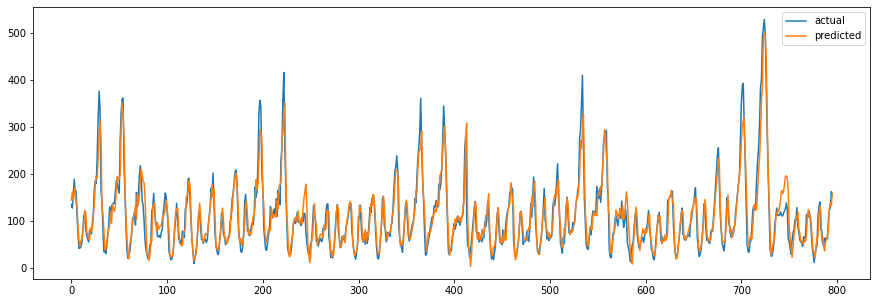

In [94]:
model = Sequential()
model.add(Dense(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

prediction = train_and_predict(model, data ,look_back=look_back)
print('Test Score: %.2f RMSE' % (prediction["score"]))
print('Test Score (relative): %.2f RMSE' % (prediction["score_relative"]))
plot_prediction(prediction)

## RNN

25/25 [==============================] - 0s 667us/step
Test Score: 25.59 RMSE
Test Score (relative): 0.24 RMSE


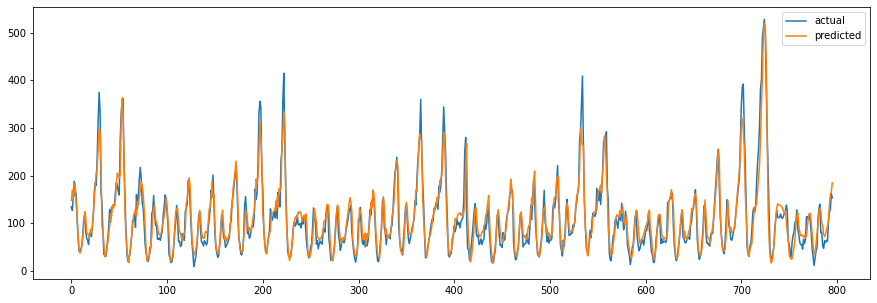

In [95]:
model = Sequential()
model.add(SimpleRNN(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

prediction = train_and_predict(model, data ,look_back=look_back, reccurent=True)
print('Test Score: %.2f RMSE' % (prediction["score"]))
print('Test Score (relative): %.2f RMSE' % (prediction["score_relative"]))
plot_prediction(prediction)

## LSTM

25/25 [==============================] - 1s 750us/step
Test Score: 23.74 RMSE
Test Score (relative): 0.22 RMSE


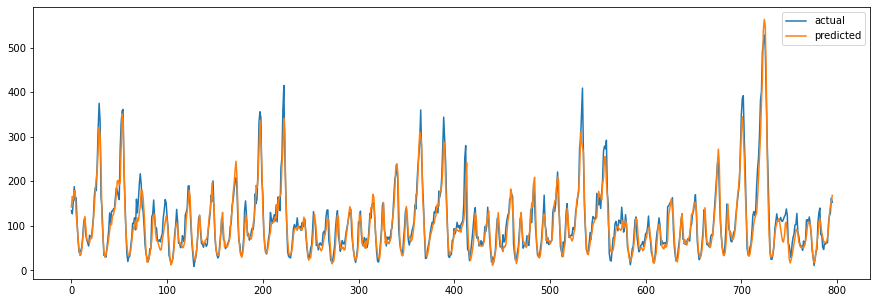

In [96]:
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

prediction = train_and_predict(model, data ,look_back=look_back, reccurent=True)
print('Test Score: %.2f RMSE' % (prediction["score"]))
print('Test Score (relative): %.2f RMSE' % (prediction["score_relative"]))
plot_prediction(prediction)